In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

In [3]:
file_list = os.listdir("/works/Data/Dacon/health_data_clf/")
file_list = [file for file in file_list if file.endswith(".csv")]
print(file_list)

['train_labels.csv', 'test_features.csv', 'train_features.csv', 'sample_submission.csv']


In [4]:
file_path = "/works/Data/Dacon/health_data_clf/"
train_label = pd.read_csv(file_path + file_list[0])
test_features = pd.read_csv(file_path + file_list[1])
train_features = pd.read_csv(file_path + file_list[2])
sample_submissuib = pd.read_csv(file_path + file_list[3])

print(train_label.shape)
print(test_features.shape)
print(train_features.shape)

(3125, 3)
(469200, 8)
(1875000, 8)


# Preprocessing data

In [5]:
def norm_fourier_transform(signal, axis=0):
    signal_mean = signal.mean(axis=axis)
    signal_std = signal.std(axis=axis)
    signal_std = np.where(signal_std==0, 1, signal_std)
    signal = (signal - signal_mean) / signal_std
    #Fourier transform
    transformed = np.fft.fft(signal, axis=axis)
    transformed = np.abs(transformed)
    freq = np.fft.fftfreq(len(transformed))
    #Extract where freq >= 0
    transformed = transformed[freq>=0]
    #Reshape
    transformed = transformed.reshape(1,transformed.shape[0],transformed.shape[1])
    return transformed


#Fourier, Oversampling
def preprocessing_data(input_set, label_set, over_count, need_col):
    
    df_filtered = input_set[["id"] + need_col].copy()
    new_input_set = np.array([])
    new_target_set = []
    
    #Reshape data
    for id_idx in range(df_filtered.id.min(),df_filtered.id.max()+1):
        if df_filtered[df_filtered.id==id_idx].shape[0]==0:
            continue
        
        signal = df_filtered[need_col][df_filtered.id==id_idx].values
        #Reshape
        signal = signal.reshape(1,signal.shape[0],signal.shape[1])
        if len(new_input_set) == 0:
            new_input_set = signal
        else:
            new_input_set = np.concatenate((new_input_set, signal), axis=0)
        new_target_set.append(label_set[label_set.id==id_idx].label.values[0])
    
    #Make numpy array
    new_target_set = np.array(new_target_set).reshape(-1)
    print("Before split input_set : {} / target_set : {}".format(new_input_set.shape, new_target_set.shape))
    
    # Split data for trainning
    x_train, x_val, y_train, y_val = train_test_split(new_input_set, new_target_set, test_size=0.3, stratify=new_target_set)
    print("After split x_train : {} y_train : {} x_val : {} y_val : {}".format(x_train.shape, y_train.shape,
                                                                              x_val.shape, y_val.shape))
    
    #Over Sampling, Normalize, Fourier transform
    add_array = np.zeros(shape=(1,int(x_train.shape[1]/2),x_train.shape[2]))
    add_label = [-1]
    unique, counts = np.unique(y_train, return_counts=True)
    label_count = dict(zip(unique, counts))
    for key, val in label_count.items():
        #Input Original data
        this_count = val
        x_sets = x_train[y_train==key]
        for x_data in x_sets:
            #Transformed
            transformed = norm_fourier_transform(signal=x_data, axis=0)
            #Add
            add_array = np.concatenate(( add_array, transformed ), axis=0)
            add_label.append(key)
        print("Before Oversampling : {}".format(add_array.shape))
        #Oversampling
        while(this_count<over_count):
            #Extract random idx
            random_idx = np.random.randint(x_train[y_train == key].shape[0])
            random_x_data = x_train[y_train == key][random_idx]
            random_shift_idx = np.random.randint(random_x_data.shape[0])
            random_x_data = np.roll(random_x_data, random_shift_idx, axis=0)
            #Transformed
            transformed = norm_fourier_transform(signal=x_data, axis=0)
            #Add
            add_array = np.concatenate(( add_array, transformed ), axis=0)
            add_label.append(key)
            
            this_count += 1
        print("After Oversampling : {}".format(add_array.shape))
        
    input_train_x = add_array[1:]
    input_train_y = np.array(add_label[1:]).reshape(-1)
    
    #Transform validation set
    val_array = np.zeros(shape=(1,int(x_val.shape[1]/2),x_val.shape[2]))
    val_label = [-1]
    for_label_idx = 0
    for x_data in x_val:
        #Transformed
        transformed = norm_fourier_transform(signal=x_data, axis=0)
        #Add
        val_array = np.concatenate(( val_array, transformed ), axis=0)
        val_label.append(y_val[for_label_idx])
        for_label_idx += 1
        
    input_val_x = val_array[1:]
    input_val_y = np.array(val_label[1:]).reshape(-1)
    
    
    print("After UpSampling x_train : {} y_train : {}".format(input_train_x.shape, input_train_y.shape))
    print("Fin data set shape = x_train : {} y_train : {} x_val : {} y_val {}".format(
        input_train_x.shape, input_train_y.shape, input_val_x.shape, input_val_y.shape))
    return input_train_x, input_train_y, input_val_x, input_val_y
        

In [6]:
x_train, y_train, x_val, y_val = preprocessing_data(input_set=train_features, label_set=train_label,
                                                    over_count=1000,
                                                    need_col=["acc_x","acc_y","acc_z","gy_x","gy_y","gy_z"])

Before split input_set : (3125, 600, 6) / target_set : (3125,)
After split x_train : (2187, 600, 6) y_train : (2187,) x_val : (938, 600, 6) y_val : (938,)
Before Oversampling : (9, 300, 6)
After Oversampling : (1001, 300, 6)
Before Oversampling : (1016, 300, 6)
After Oversampling : (2001, 300, 6)
Before Oversampling : (2015, 300, 6)
After Oversampling : (3001, 300, 6)
Before Oversampling : (3017, 300, 6)
After Oversampling : (4001, 300, 6)
Before Oversampling : (4025, 300, 6)
After Oversampling : (5001, 300, 6)
Before Oversampling : (5019, 300, 6)
After Oversampling : (6001, 300, 6)
Before Oversampling : (6018, 300, 6)
After Oversampling : (7001, 300, 6)
Before Oversampling : (7019, 300, 6)
After Oversampling : (8001, 300, 6)
Before Oversampling : (8069, 300, 6)
After Oversampling : (9001, 300, 6)
Before Oversampling : (9027, 300, 6)
After Oversampling : (10001, 300, 6)
Before Oversampling : (10015, 300, 6)
After Oversampling : (11001, 300, 6)
Before Oversampling : (11017, 300, 6)
Afte

# Shuffle

In [7]:
shuffle_idx = np.random.permutation(len(x_train))

x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]

# Save

In [8]:
np.save("/works/Data/Dacon/health_data_clf/transformed/x_train_norm_fourier_oversample_210208", x_train)
np.save("/works/Data/Dacon/health_data_clf/transformed/y_train_norm_fourier_oversample_210208", y_train)
np.save("/works/Data/Dacon/health_data_clf/transformed/x_val_norm_fourier_oversample_210208", x_val)
np.save("/works/Data/Dacon/health_data_clf/transformed/y_val_norm_fourier_oversample_210208", y_val)

# Load

In [3]:
x_train = np.load("/works/Data/Dacon/health_data_clf/transformed/x_train_norm_fourier_oversample_210208.npy")
y_train = np.load("/works/Data/Dacon/health_data_clf/transformed/y_train_norm_fourier_oversample_210208.npy")
x_val = np.load("/works/Data/Dacon/health_data_clf/transformed/x_val_norm_fourier_oversample_210208.npy")
y_val = np.load("/works/Data/Dacon/health_data_clf/transformed/y_val_norm_fourier_oversample_210208.npy")

In [4]:
shuffle_idx = np.random.permutation(len(x_train))

x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]

In [5]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(61062, 300, 6) (61062,) (938, 300, 6) (938,)


# Build model

In [6]:
def return_tensorflow_model(input_shape_tuple):
    input_tens = tf.keras.Input(shape=input_shape_tuple)
    x = tf.keras.layers.LSTM(16)(input_tens)
    x = tf.keras.layers.Dense(61, activation="softmax")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    print(model.summary())
    return model

In [7]:
model = return_tensorflow_model(input_shape_tuple=(300,6))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 6)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1472      
_________________________________________________________________
dense (Dense)                (None, 61)                1037      
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_val, y_val))

Train on 61062 samples, validate on 938 samples
Epoch 1/100
61062/61062 [==============================] - 6s 93us/sample - loss: 0.1349 - accuracy: 0.9775 - val_loss: 3.8586 - val_accuracy: 0.3305
Epoch 2/100
61062/61062 [==============================] - 7s 114us/sample - loss: 0.1321 - accuracy: 0.9776 - val_loss: 3.8482 - val_accuracy: 0.3273
Epoch 3/100
61062/61062 [==============================] - 6s 104us/sample - loss: 0.1273 - accuracy: 0.9782 - val_loss: 3.8193 - val_accuracy: 0.3401
Epoch 4/100
61062/61062 [==============================] - 7s 119us/sample - loss: 0.1228 - accuracy: 0.9787 - val_loss: 3.7664 - val_accuracy: 0.3454
Epoch 5/100
61062/61062 [==============================] - 7s 110us/sample - loss: 0.1201 - accuracy: 0.9788 - val_loss: 3.7387 - val_accuracy: 0.3443
Epoch 6/100
61062/61062 [==============================] - 7s 121us/sample - loss: 0.2370 - accuracy: 0.9575 - val_loss: 3.8244 - val_accuracy: 0.3177
Epoch 7/100
61062/61062 [======================

Epoch 55/100
61062/61062 [==============================] - 7s 111us/sample - loss: 0.0976 - accuracy: 0.9815 - val_loss: 3.4173 - val_accuracy: 0.4243
Epoch 56/100
61062/61062 [==============================] - 7s 110us/sample - loss: 0.0915 - accuracy: 0.9825 - val_loss: 3.3734 - val_accuracy: 0.4168
Epoch 57/100
61062/61062 [==============================] - 7s 110us/sample - loss: 0.0905 - accuracy: 0.9828 - val_loss: 3.2956 - val_accuracy: 0.4360
Epoch 58/100
61062/61062 [==============================] - 7s 111us/sample - loss: 0.0911 - accuracy: 0.9826 - val_loss: 3.2999 - val_accuracy: 0.4328
Epoch 59/100
61062/61062 [==============================] - 6s 101us/sample - loss: 0.0888 - accuracy: 0.9827 - val_loss: 3.3146 - val_accuracy: 0.4307
Epoch 60/100
61062/61062 [==============================] - 7s 115us/sample - loss: 0.0878 - accuracy: 0.9830 - val_loss: 3.2726 - val_accuracy: 0.4318
Epoch 61/100
61062/61062 [==============================] - 7s 114us/sample - loss: 0.09

# Predict

In [22]:
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)

# Result

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

def draw_confusion_matrix_and_print_accuracy(predicted_label, real_label):
    print(accuracy_score(real_label, predicted_label))
    print(confusion_matrix(real_label, predicted_label))

In [24]:
def return_armax(arrs):
    return np.argmax(arrs, axis=1)

In [25]:
train_predict = return_armax(arrs=train_predict)
val_predict = return_armax(arrs=val_predict)

In [26]:
draw_confusion_matrix_and_print_accuracy(predicted_label=train_predict, real_label=y_train)

0.9832465363073597
[[993   0   0 ...   0   2   0]
 [  0 986   0 ...   0   1   0]
 [  0   0 988 ...   0   0   0]
 ...
 [  0   0   0 ... 988   0   0]
 [  0   0   0 ...   0 988   0]
 [  0   1   0 ...   0   1 967]]


In [27]:
draw_confusion_matrix_and_print_accuracy(predicted_label=val_predict, real_label=y_val)

0.42430703624733473
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [28]:
import seaborn as sns
#From https://www.kaggle.com/agungor2/various-confusion-matrix-plots
def plot_cm(y_true, y_pred, figsize=(20,20)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# With Label 26

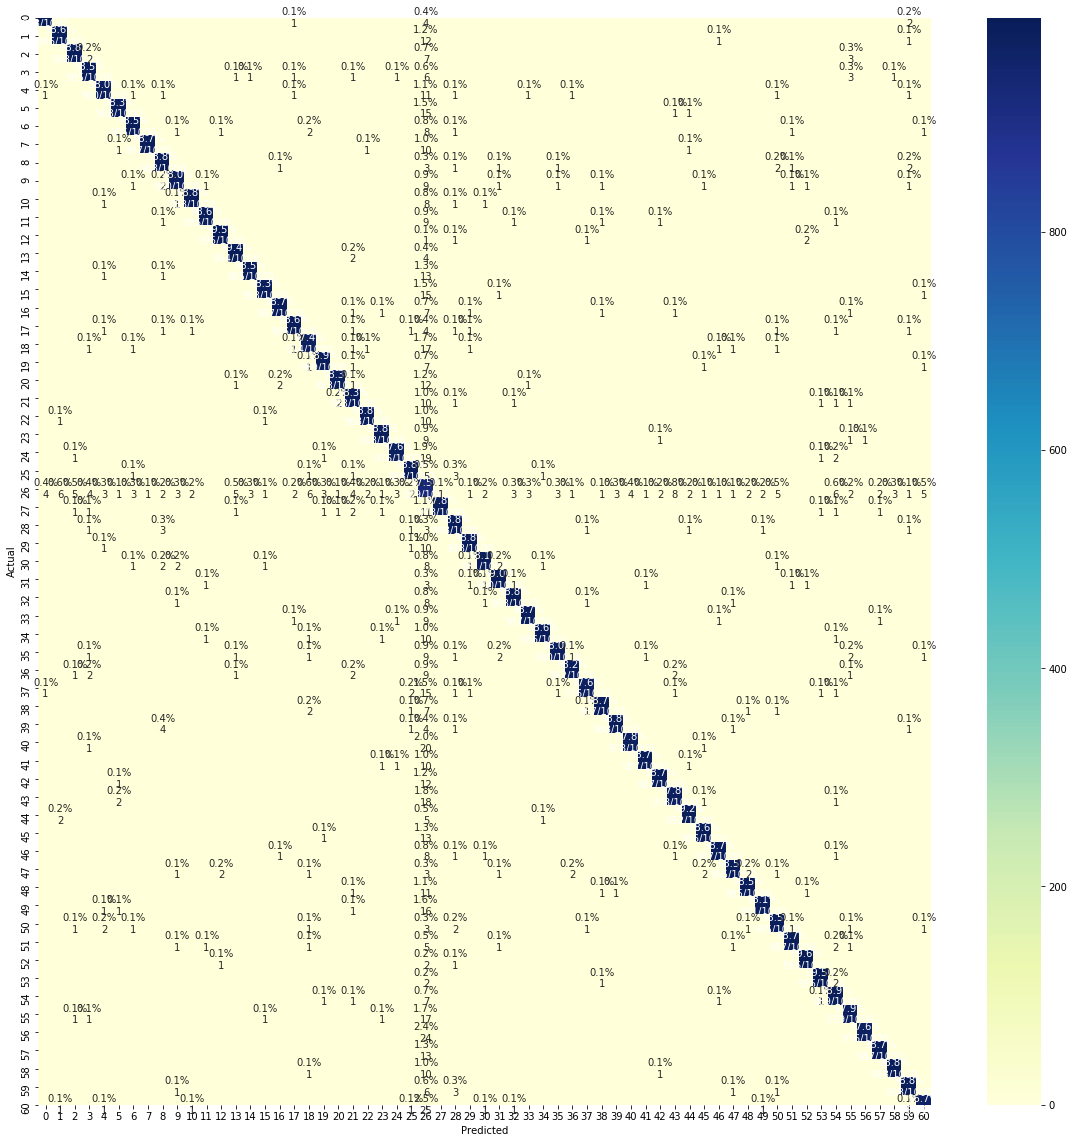

In [29]:
plot_cm(y_true=y_train, y_pred=train_predict)

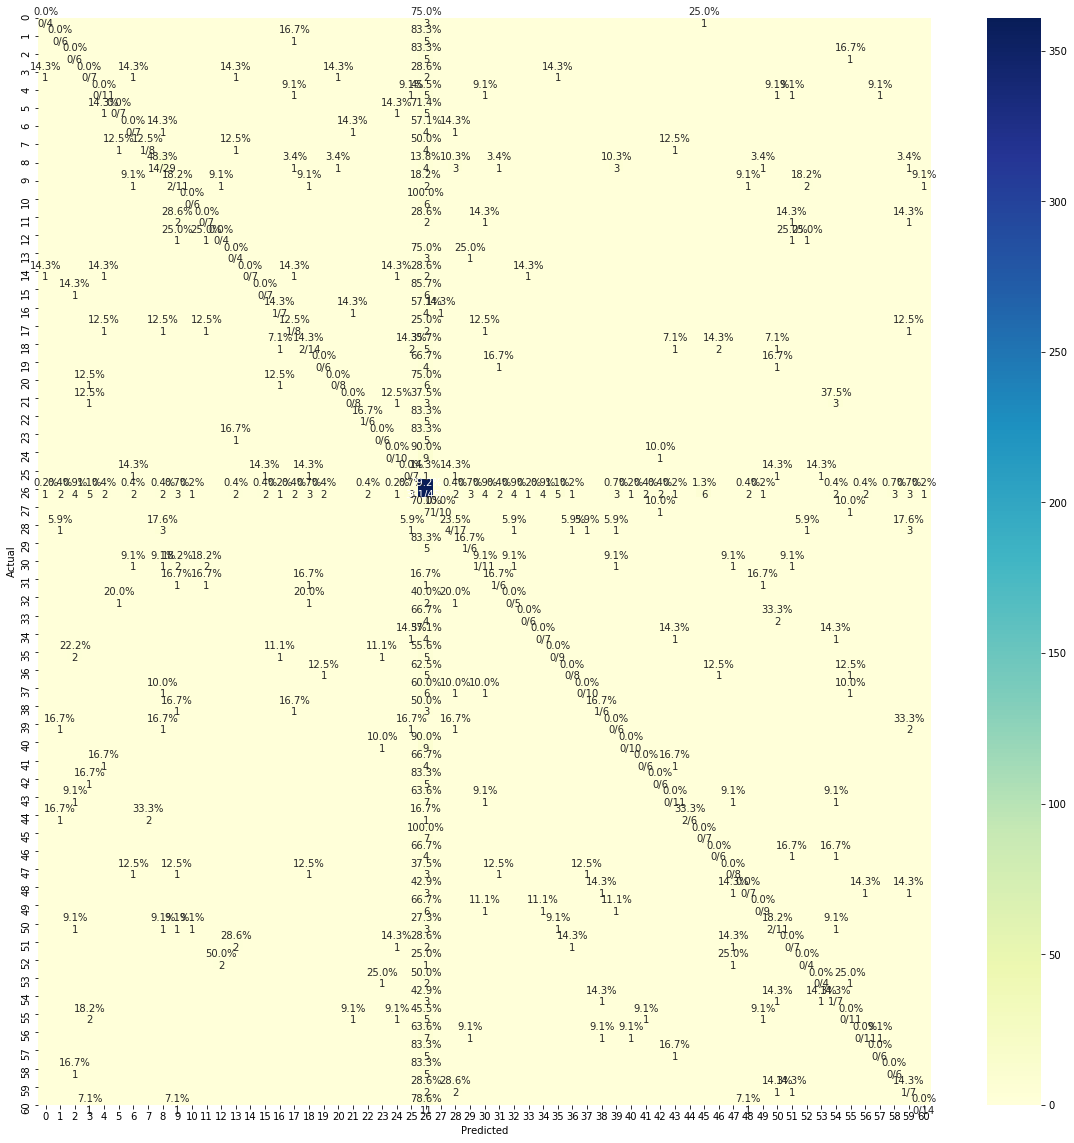

In [30]:
plot_cm(y_true=y_val, y_pred=val_predict)

# Without Label 26

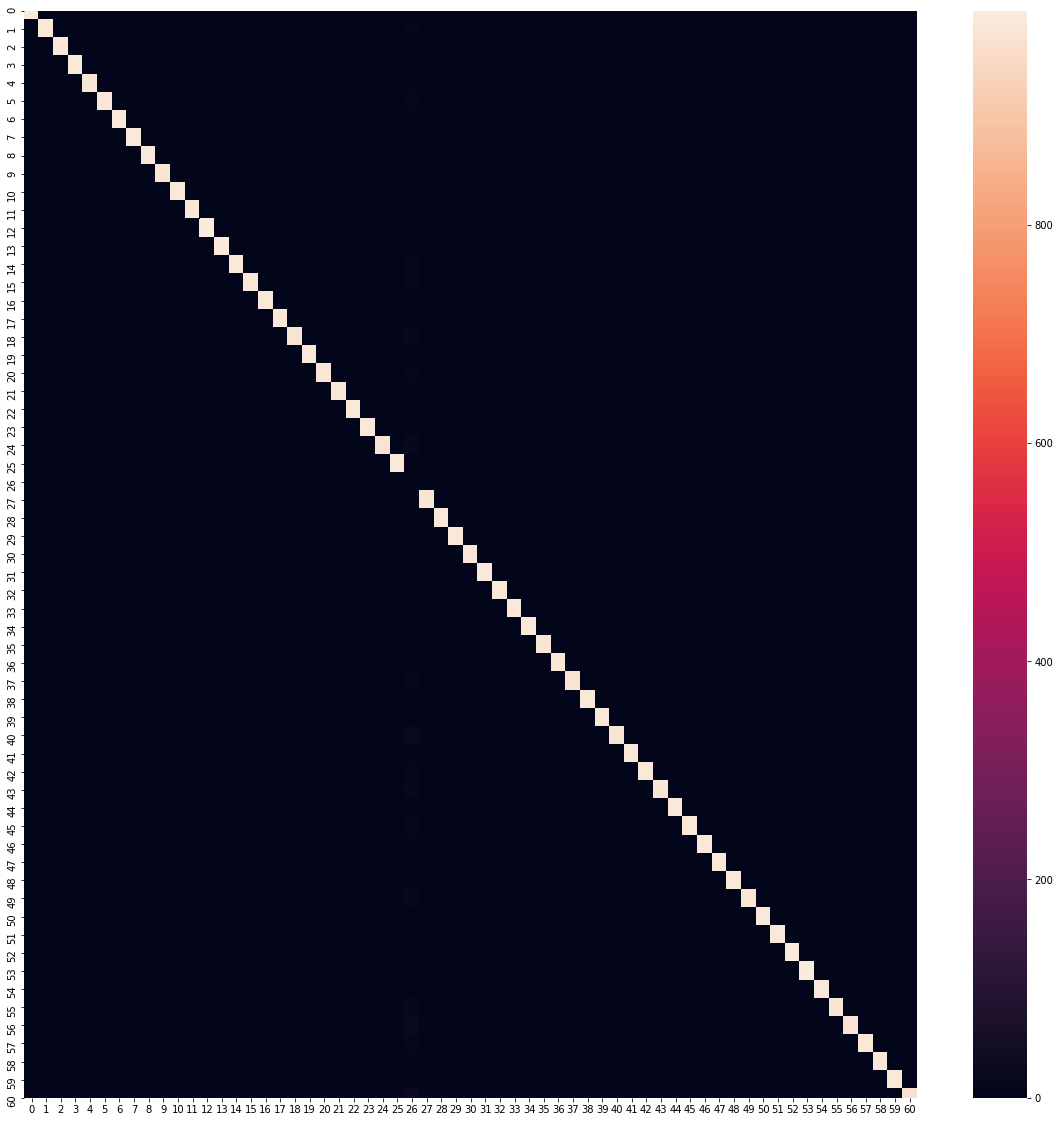

In [31]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix(y_train[y_train!=26], train_predict[y_train!=26]), ax=ax)
plt.show()

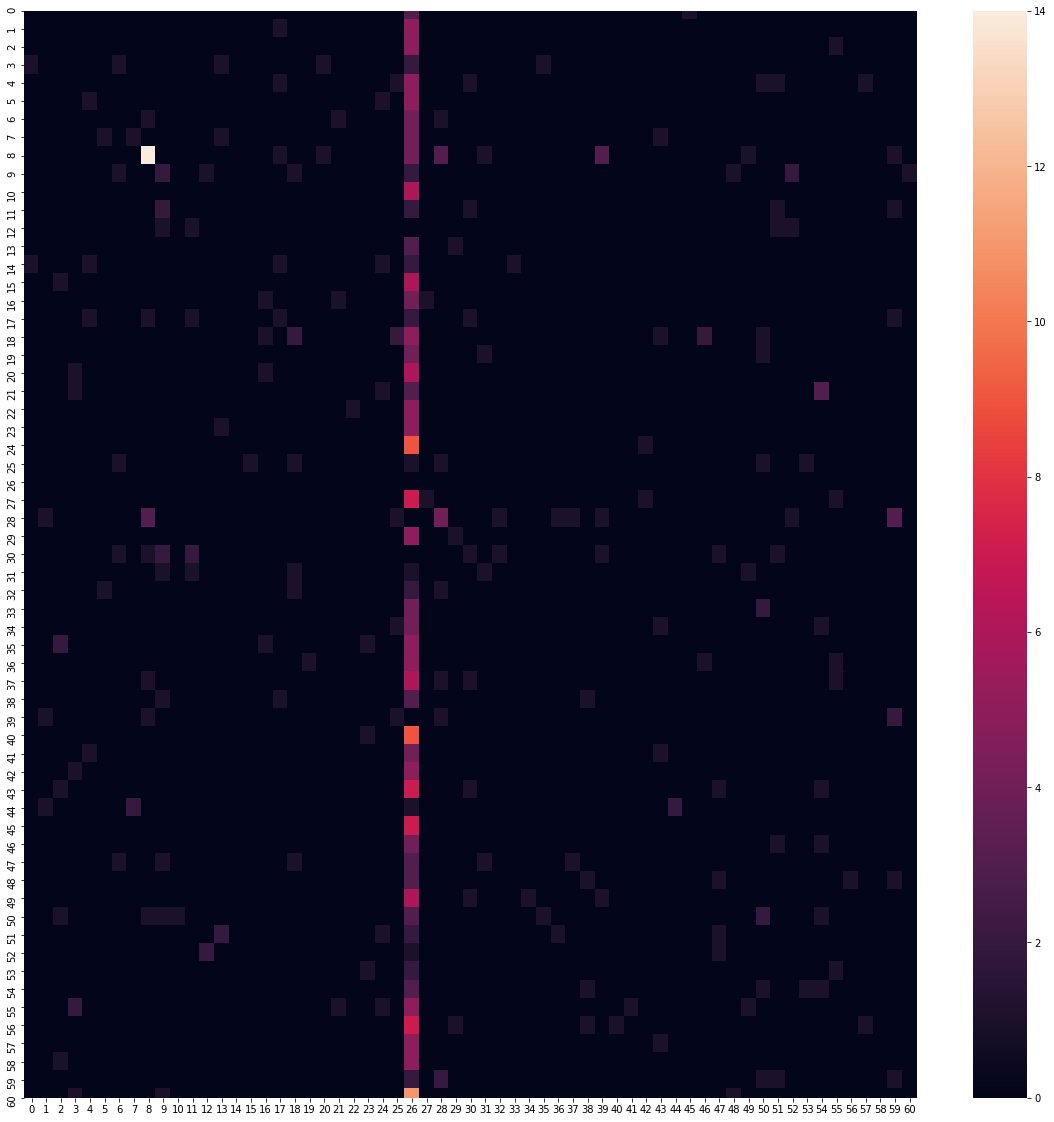

In [32]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix(y_val[y_val!=26], val_predict[y_val!=26]), ax=ax)
plt.show()